In [1]:
import os
import glob
import numpy as np
import awkward

In [2]:
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

/home/duncansw/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# v14 8gev (updated for full 2e14 pn sample)
presel_eff = {1: 0.9952855229150378, 10: 0.9976172400798192, 100: 0.9979411114121182, 1000: 0.9981519444725636, 0: 0.03282988102560554}

In [5]:
sig_filelist = glob.glob('/home/duncansw/LDMX-scripts/GraphNet/plot_data/pnx_v14_8gev_full_1r_5en3_128/v14_8gev_1*.parquet') + \
                 glob.glob('/home/duncansw/LDMX-scripts/GraphNet/plot_data/pnx_v14_8gev_full_1r_5en3_128/v14_8gev_0*.parquet')
bkg_filelist = glob.glob('/home/duncansw/LDMX-scripts/GraphNet/plot_data/pnx_v14_8gev_full_1r_5en3_128/*pn*.parquet')

In [6]:
sig_tables = [awkward.from_parquet(f) for f in sig_filelist]
#print(sig_tables[0]['ParticleNet_extra_label'])
bkg_tables = [awkward.from_parquet(f) for f in bkg_filelist]

In [7]:
load_branches = [
    'discValue_',
    'recoilX_',
    'recoilY_',
     
    'ParticleNet_extra_label',
    'ParticleNet_disc',
    'TargetSPRecoilE_pt', # use this for plotting: this is the recoil electron pT at TargetSP
    'maxPE'
]

In [8]:
def load_dict(sig_tables, bkg_tables):
    a = {}
    for k in load_branches:
        #print("Loading "+k)
        arrs = []
        for tab in sig_tables + bkg_tables:
            #print(awkward.type(tab))
            #print(tab)
            #print(tab['TargetSPRecoilE_pt'])
            #print(awkward.fields(tab))
            arr = tab[k] if k in awkward.fields(tab) else np.zeros_like(tab['ParticleNet_disc'])
            arrs.append(arr)
        a[k] = awkward.concatenate(arrs)
        if k.startswith('EcalVeto'):
            #a[k] = a[k].regular()
            a[k] = awkward.to_regular(a[k])
            if a[k].ndim==2 and len(a[k][0]) == 1:  #a[k].shape[1]==1:
                a[k] = a[k][:,0]
        print("   Found {} events".format(len(a[k])))
    return a

a = load_dict(sig_tables, bkg_tables)

print("Done")

   Found 24793783 events
   Found 24793783 events
   Found 24793783 events
   Found 24793783 events
   Found 24793783 events
   Found 24793783 events
   Found 24793783 events
Done


In [9]:
for k in a.keys():
    print(k, awkward.type(a[k]))

discValue_ 24793783 * var * float64
recoilX_ 24793783 * var * float64
recoilY_ 24793783 * var * float64
ParticleNet_extra_label 24793783 * int64
ParticleNet_disc 24793783 * float64
TargetSPRecoilE_pt 24793783 * var * float64
maxPE 24793783 * var * float64


In [10]:
def to_categorical(y, num_classes=None):
    """Converts a class vector (integers) to binary class matrix.
    E.g. for use with categorical_crossentropy.
    # Arguments
        y: class vector to be converted into a matrix
            (integers from 0 to num_classes).
        num_classes: total number of classes.
    # Returns
        A binary matrix representation of the input.
    """
    y = np.array(y, dtype='int').ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype='int')
    categorical[np.arange(n), y] = 1
    return categorical

def plotROC(y_preds, y_truth, sample_weight=None, output=None, labels=['signal'], sig_eff=1, bkg_eff=1, energy=0, **kwargs):
    from sklearn.metrics import auc, roc_curve, accuracy_score

    fpr = dict()
    tpr = dict()
    thresholds= dict()
    roc_auc = dict()
    outputs = {}

    plt.figure()

    for label, pred in zip(labels, y_preds):
        print("Label: ", label)
        fpr[label], tpr[label], thresholds[label] = roc_curve(y_truth, pred, sample_weight=sample_weight)
        roc_auc[label] = auc(fpr[label], tpr[label])
        fpr[label] *= bkg_eff
        tpr[label] *= sig_eff

        legend = '%s (auc* = %0.6f)' % (label, roc_auc[label])
        print(legend)
        eff = get_signal_effs(fpr[label], tpr[label], thresholds[label])
        outputs[label] = eff
        print(eff)
        plt.plot(fpr[label], tpr[label], label=legend)
#     plt.plot([0, 1], [1, 0], 'k--')
    plt.xlim(kwargs.get('xlim', [0, 1]))
    plt.ylim(kwargs.get('ylim', [0, 1]))
    plt.xlabel('False positive rate ($\epsilon_{B}$)')
    plt.ylabel('True positive rate ($\epsilon_{S}$)')
#     plt.title('Receiver operating characteristic example')
    plt.legend(loc='best')
    if kwargs.get('logy', False):
        plt.yscale('log')
    if kwargs.get('logx', False):
        plt.xscale('log')
    plt.grid()
    # TEMPORARY TITLE
    plt.title(str(k)+" MeV", fontdict = {'fontsize' : 15})
    #plt.title("All events, "+str(k)+" MeV", fontdict = {'fontsize' : 15})
    if output:
        plt.savefig(output)
#     return {'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds}
    return outputs


def plotROC_multi(y_preds_, y_truth_, sample_weight_=None, output=None, labels=['signal'], sig_eff=1, bkg_eff=1, energy=0, **kwargs):
    from sklearn.metrics import auc, roc_curve, accuracy_score

    # y_preds, etc are now tuples of (a, b, c) (1reg, 2reg, 3reg)
    #plt.figure()
    #fig, ax = plt.subplots()
    
    for i in range(1):  # 1, 2, 3 regions
        
        fpr = dict()
        tpr = dict()
        thresholds= dict()
        roc_auc = dict()
        outputs = {}

        #plt.figure()

        y_preds = y_preds_[i]
        y_truth = y_truth_[i]
        sample_weight = sample_weight_[i]
        print("Y_TRUTH:")
        print(y_truth[:10])
        for label, pred in zip(labels, y_preds):
            if label == 'BDT' and i < 1:  continue
            print("Label: ", label)
            fpr[label], tpr[label], thresholds[label] = roc_curve(y_truth, pred, sample_weight=sample_weight)
            roc_auc[label] = auc(fpr[label], tpr[label])
            fpr[label] *= bkg_eff
            tpr[label] *= sig_eff
            
            if label == 'BDT':
                legend = '%s\n(auc* = %0.6f)' % (label+' (old Gabriel)', roc_auc[label])
            #elif i == 0:
                #legend = '(1,1)-reg SplitNetX\n(auc* = %0.6f)' % (roc_auc[label])
                #legend = '1-reg SplitNet\n(auc* = %0.6f)' % (roc_auc[label])
            else:
                #legend = '%i-reg %s, PN \n(auc* = %0.6f)' % (i+1, label, roc_auc[label])
                legend = f'{k} MeV \n(AUC={roc_auc[label]:0.4f})'
            #else:
                #legend = '1-reg SplitNet\n(auc* = %0.6f)' % (roc_auc[label])
            print(legend)
            eff = get_signal_effs(fpr[label], tpr[label], thresholds[label])
            outputs[label] = eff
            print(eff)
            print(len(eff))
            #print(tpr[label][:10])
            #print(len(fpr[label]))
            ax.plot(fpr[label], tpr[label], label=legend, color=colors[n])
#     plt.plot([0, 1], [1, 0], 'k--')
    ax.set_xlim(kwargs.get('xlim', [0, 1]))
    ax.set_ylim(kwargs.get('ylim', [0, 1]))
    ax.set_xlabel('False positive rate ($\epsilon_{B}$)', fontsize=14)
    ax.set_ylabel('True positive rate ($\epsilon_{S}$)', fontsize=14)
#     plt.title('Receiver operating characteristic example')
    ax.legend(loc='best')
    if kwargs.get('logy', False):
        ax.set_yscale('log')
    if kwargs.get('logx', False):
        ax.set_xscale('log')
    ax.grid()
    # TEMPORARY TITLE
    ax.set_title(str(k)+" MeV w/ PN Background", fontdict = {'fontsize' : 15})
    #ax.grid(color='gainsboro')
    #plt.title("All events, "+str(k)+" MeV", fontdict = {'fontsize' : 15})
    if output:
        plt.savefig(output, facecolor='w', dpi=250)
#     return {'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds}
    return outputs


mistags=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
def get_signal_effs(fpr, tpr, thresholds, mistags=mistags):
    outputs = []
    for m in mistags:
        idx = next(idx for idx, v in enumerate(fpr) if v > m)
        outputs.append((fpr[idx], tpr[idx], thresholds[idx]))
    return outputs

In [11]:
#pT = np.array(a['TargetSPRecoilE_pt']).T[0]
test_extra_labels = a['ParticleNet_extra_label']#[pT != -999]
test_labels = test_extra_labels>0

<IPython.core.display.Javascript object>


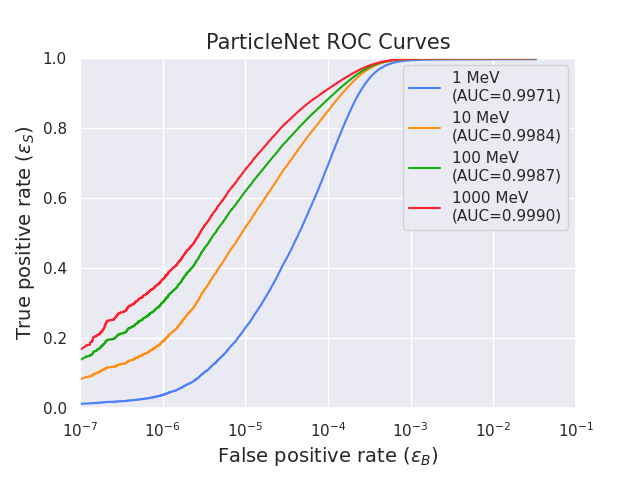

1 MeV
<class 'list'>
Y_TRUTH:
[True, True, True, True, True, True, True, True, True, True]
Label:  SplitNet
1 MeV 
(AUC=0.9971)
[(0.0010000452262903187, 0.99238859266503, 0.38924650211524875), (0.00010000341960958693, 0.6931749038209154, 0.8259511920347394), (1.0000709634107006e-05, 0.22855351849083394, 0.9213244509246079), (1.0000709634107006e-06, 0.037362432812322446, 0.9688257801717208), (1.1765540746008242e-07, 0.012433897050183187, 0.9996732291119655), (1.1765540746008242e-07, 0.012433897050183187, 0.9996732291119655), (3.6767314831275756e-09, 2.91875517609934e-05, 0.9998865925765203)]
7
10 MeV
<class 'list'>
Y_TRUTH:
[True, True, True, True, True, True, True, True, True, True]
Label:  SplitNet
10 MeV 
(AUC=0.9984)
[(0.0010000084589754873, 0.9959519805052335, 0.38925995020918996), (0.00010000341960958693, 0.8477264325309961, 0.8259511920347394), (1.0000709634107006e-05, 0.515508646652681, 0.9213244509246079), (1.0000709634107006e-06, 0.18950103324583636, 0.9688257801717208), (1.17

In [12]:
roc_info = {}
#y_preds_ = [[a['ParticleNet_disc'], a['discValue_']], [b['ParticleNet_disc'], b['discValue_']], [c['ParticleNet_disc'], c['discValue_']]]
y_preds_ = [[a['ParticleNet_disc'], a['discValue_']]]
#test_labels_ = [test_labels, test_labels_b, test_labels_c]
test_labels_ = [test_labels]
#print(a['ParticleNet_disc'][:10])
import seaborn as sns; sns.set()
fig, ax = plt.subplots()
colors = ['#4A7DFF', '#14AD0C', '#FF212E', '#FF8F13', '#871EFE'] 
colors = ['#4A7DFF', '#FF8F13', '#14AD0C', '#FF212E']
n = 0
for k in presel_eff:
    if k > 0:
        mass = '%d MeV' % k
        print(mass)
        weights = [np.logical_or(test_extra_labels==0, test_extra_labels==k)]
                  #np.logical_or(test_extra_labels_c==0, test_extra_labels_c==k)]
        print(type(weights))
        roc_info[k] = plotROC_multi(y_preds_, test_labels_, 
                sample_weight_=weights,
                sig_eff=presel_eff[k], bkg_eff=presel_eff[0],
                labels=['SplitNet', 'BDT'], xlim=[1e-7, 0.1], ylim=[0, 1], logx=True, energy=k)
        n+=1
ax.set_title('ParticleNet ROC Curves', fontsize=15)
plt.gcf().subplots_adjust(bottom=0.15)
#plt.savefig('ROC_v14_8gev_full_all_masses', facecolor='w', dpi=300)
# NOTE:  add 'BDT' to labels list if desired

In [13]:
disc_threshold = 0.7335808

bkg_pt = np.array(a['TargetSPRecoilE_pt'][test_extra_labels==0])
bkg_disc_value = a['ParticleNet_disc'][test_extra_labels==0]
bkg_maxPE = a['maxPE'][test_extra_labels==0]

nPass = np.sum( (bkg_disc_value > disc_threshold) * (bkg_pt.T[0] != -999) )
nPass_veto = np.sum( (bkg_disc_value > disc_threshold) * (bkg_pt.T[0] != -999) * (bkg_maxPE < 8) )

print(nPass)
print(nPass_veto)

74805
1


In [14]:
masses = [0, 1, 10, 100, 1000]
pT = {}
nEvents = {}
for m in masses:
    pT[m] = np.array(a['TargetSPRecoilE_pt'][test_extra_labels==m]).T[0]
    print(len(pT[m]))
    pT[m] = pT[m]
    print(len(pT[m]))
    pT[m] = pT[m][pT[m] != -999]
    nEvents[m] = len(pT[m])
    print(len(pT[m]))
print(nEvents)

8929094
8929094
8929088
3785062
3785062
3783143
3659756
3659756
3630028
4661474
4661474
4486595
3758397
3758397
3703161
{0: 8929088, 1: 3783143, 10: 3630028, 100: 4486595, 1000: 3703161}


In [15]:
# threshold = [474896 ->10, 74805 -> 1, 1k -> 0, 100 -> 0]   # 10k -> 0
#thresholds = [0.222477, 0.7335808, 0.94611, 0.98472]  # 0.94611
#thresholds = [0.98472, 0.94611, 0.7335808, 0.222477]
thresholds = [0.94611, 0.87439, 0.7335808, 0.222477]    #0.94611
thresholds = [0.999, 0.94611, 0.87439, 0.7335808, 0.222477] 
pT_pass = {}
for m in masses:
    disc_value = np.array(a['ParticleNet_disc'][test_extra_labels==m])
    disc_value = disc_value
    print(disc_value.shape)
    pt = np.array(a['TargetSPRecoilE_pt'][test_extra_labels==m]).T[0]
    #print(pt.T[0])
    print(pt.shape)
    disc_value = disc_value[pt!=-999]
    pT_pass[m] = [pT[m][disc_value > threshold] for threshold in thresholds]
    print(len(pT_pass[m]))

(8929094,)
(8929094,)
5
(3785062,)
(3785062,)
5
(3659756,)
(3659756,)
5
(4661474,)
(4661474,)
5
(3758397,)
(3758397,)
5


<IPython.core.display.Javascript object>


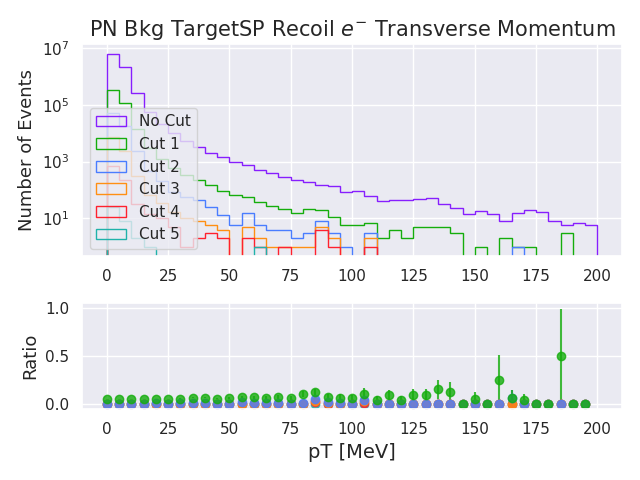

/tmp/ipykernel_248110/3150559018.py:33: RuntimeWarning: invalid value encountered in divide
  ratio_arr = val / n1
/tmp/ipykernel_248110/3150559018.py:34: RuntimeWarning: invalid value encountered in divide
  err = (val / n1) * ( (1/np.sqrt(val)) + (1/np.sqrt(n1)) )
/tmp/ipykernel_248110/3150559018.py:34: RuntimeWarning: divide by zero encountered in divide
  err = (val / n1) * ( (1/np.sqrt(val)) + (1/np.sqrt(n1)) )
/tmp/ipykernel_248110/3150559018.py:34: RuntimeWarning: invalid value encountered in multiply
  err = (val / n1) * ( (1/np.sqrt(val)) + (1/np.sqrt(n1)) )


<IPython.core.display.Javascript object>


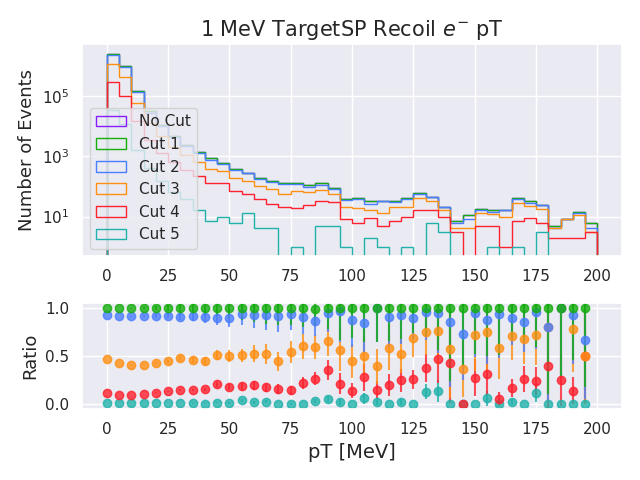

<IPython.core.display.Javascript object>


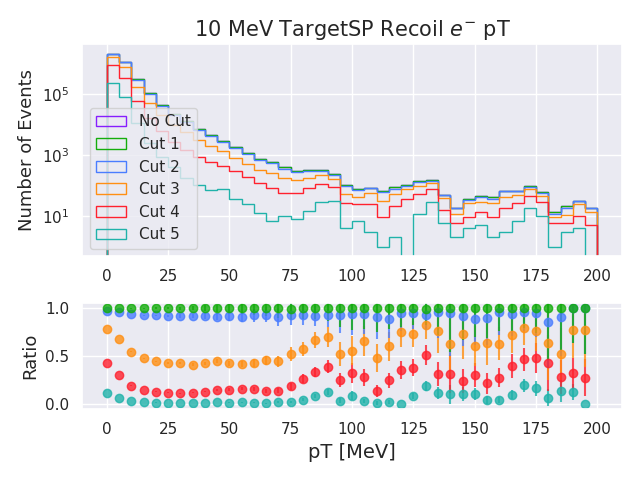

<IPython.core.display.Javascript object>


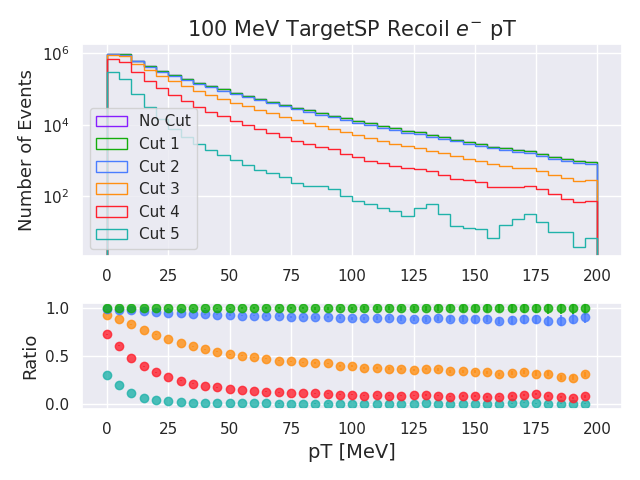

<IPython.core.display.Javascript object>


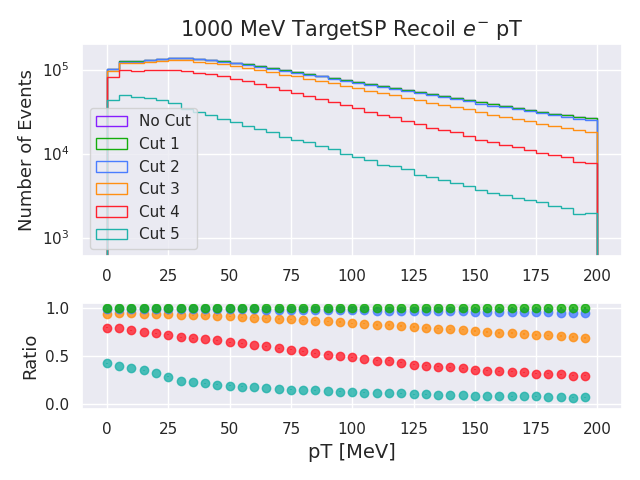

In [16]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import seaborn as sns; sns.set()

#colors = ['#4A7DFF', '#14AD0C', '#FF212E', '#FF8F13', '#871EFE']
colors = ['lightseagreen', '#FF212E', '#FF8F13', '#4A7DFF', '#14AD0C', '#871EFE']

for m in masses:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios': [2, 1]})
    #if m == 1000:
        #ax1.set_ylim(100, 1300)
    vals = [pT[m], pT_pass[m]]
    bins = np.linspace(-50, 200, 51)
    #labels = ['N bkg ~ $5 \\times 10^{5} \\to 10$', 'N bkg ~ $7.5 \\times 10^{4} \\to 1$', 
               #'N bkg ~ $1 \\times 10^{3} \\to 0$', 'N bkg ~ $1 \\times 10^{2} \\to 0$']
    #labels = ['N bkg ~ $1 \\times 10^{3} \\to 0$', 'N bkg ~ $1 \\times 10^{4} \\to 0$', 
             #'N bkg ~ $7.5 \\times 10^{4} \\to 1$', 'N bkg ~ $5 \\times 10^{5} \\to 10$']
    labels = ['Cut 5', 'Cut 4', 'Cut 3', 'Cut 2', 'Cut 1']
    n1, bins, _ = ax1.hist(vals[0], bins=bins, range=(0, 250), density=False, stacked=False, histtype='step', color=colors[-1],
                log=True, label='No Cut')
    n2, bins, _ = ax1.hist(vals[1], bins=bins, range=(0, 250), density=False, stacked=False, histtype='step', color=colors[:-1],
                    log=True, label=labels)
    #n1, bins, _ = ax1.hist(vals[0], bins=bins, range=(0, 250), density=False, stacked=False, histtype='step', color=colors[0], 
                 #log=True, label='Inclusive')
    #n2, bins, _ = ax1.hist(vals[1], bins=bins, range=(0, 250), density=False, stacked=False, histtype='step', color=colors[3], 
                 #log=True, label=f'ParticleNetX_disc > {disc_threshold}')
    ax1.legend(loc='lower left')
    
    ratio_arrs = []
    errs = []
    for val in n2:
        ratio_arr = val / n1
        err = (val / n1) * ( (1/np.sqrt(val)) + (1/np.sqrt(n1)) ) 
        #print(type(ratio_arr))
        #print(len(ratio_arr))       
        #print(len(bins[:-1]))
        ratio_arrs.append(ratio_arr)
        errs.append(err)
    
    for i, ratio_arr in enumerate(ratio_arrs):

        ax2.errorbar(bins[:-1],     
            ratio_arr,
            yerr=errs[i],
            fmt='o',
            alpha=0.8,
            color=colors[i])

    '''
    ax2.errorbar(bins[:-1],     # this is what makes it comparable
        n2 / n1, # maybe check for div-by-zero!
        alpha=0.8,
        yerr = (n2 / n1) * ( (1/np.sqrt(n2)) + (1/np.sqrt(n1)) ),
        fmt='o',
        color=colors[1]        
                            )
    '''
    
    ax1.set_xlim(-10, 210)
    if m==1000:
        ax1.set_ylim(6e2, 2e5)
    ax2.set_xlim(-10, 210)
    ax2.set_ylim(-0.05, 1.05)
    #ax2.grid()
    ax2.set_xlabel("pT [MeV]", fontsize=14)
    
    ax1.set_ylabel('Number of Events', fontsize=13)
    
    ax1.set_title(f'{m} MeV TargetSP Recoil $e^{{-}}$ pT' if m!=0 else 'PN Bkg TargetSP Recoil $e^{{-}}$ Transverse Momentum', fontsize=15)
    ax2.set_ylabel('Ratio', fontsize=13)
    plt.tight_layout()
    plt.savefig(f'pT_bias_{m}', facecolor='w', dpi=300)

In [17]:
pn_sig_disc = {}

for m in masses[1:]:
    pn_sig_disc[m] = a['ParticleNet_disc'][test_extra_labels==m]

pn_sig_pass = {}
for m in masses[1:]:
    pn_sig_pass[m] = np.sum( (pn_sig_disc[m] > disc_threshold) * (a['TargetSPRecoilE_pt'][test_extra_labels==m] != -999) * (a['maxPE'][test_extra_labels==m] < 8) )

pn_sig_eff = {}
for m in masses[1:]:
    pn_sig_eff[m] = (pn_sig_pass[m] / nEvents[m]) * presel_eff[m]
    
print(pn_sig_eff)

{1: 0.8760670313836287, 10: 0.8970483042934262, 100: 0.8936696503870479, 1000: 0.7573166805339802}
